# GhazalGen: Deep Learning Poetry with Hafez Shirazi

Welcome to the Deep Learning Homework Notebook! In this notebook, we'll explore the fascinating world of natural language processing using deep learning techniques. Our dataset consists of the timeless ghazals of Hafez Shirazi, a renowned Persian poet whose words resonate through the ages. Through this notebook, you'll learn how to train a deep learning model to generate poetry in the style of Hafez, unlocking the secrets of his mystical verses.

***Hafez***

Hafez Shirazi, often referred to simply as 'Hafez', was a 14th-century Persian poet whose lyrical genius has captivated hearts for centuries. Born in Shiraz, Iran, Hafez is celebrated as one of the greatest poets in Persian literature, revered for his mastery of the ghazal form. His poetry, characterized by its profound spiritual insight, rich symbolism, and exquisite imagery, explores themes of love, mysticism, and the divine. Hafez's works continue to inspire and enchant readers worldwide, transcending time and cultural boundaries.

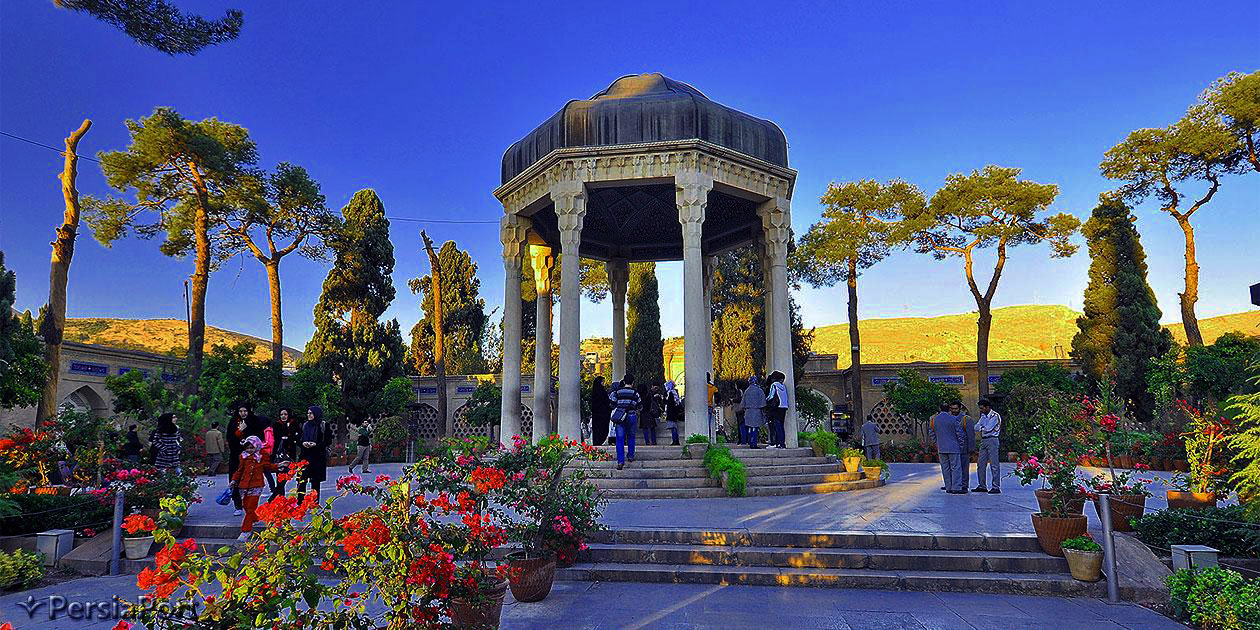

[https://www.iranmirrorbd.com/en/wp-content/uploads/2020/10/hafez.jpg](https://www.iranmirrorbd.com/en/wp-content/uploads/2020/10/hafez.jpg)


Please fill in the specified blanks or placeholders in the code cells below. You will find comments indicating where to input your code or data. Make sure to carefully read and follow the instructions provided. **You are only allowed to fill in the blanks.**


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
import warnings

import string

import matplotlib.pyplot as plt
import seaborn as sns

## Load data

This cell reads the contents of the 'divan.txt' file, which should be in the same directory as this notebook. The text will be stored in the variable 'document' for processing.


In [4]:
############################ Start Code #############################
file = open("divan.txt", "r")
document = file.read()
############################ End Code ###############################
print(document[:70])

"O beautiful wine-bearer, bring fort h the cup and put it to my lips,"


## Data prepration

In this section, we preprocess the text data from the 'divan.txt' file to prepare it for training the model.

1. `text_to_word_list`: Converts the document into a list of words.
2. `clean_words`: Removes punctuation from the list of words.
3. `generate_vocabulary`: Generates the vocabulary from the list of words.
4. `build_word_dictionary`: Creates dictionaries for mapping words to integers and vice versa.
5. `generate_training_batches`: Generates batches of input-output pairs for training the model.

Make sure to understand each step before proceeding to the next section.


In [5]:
def text_to_word_list(document):
  hemistiches = document.split('\n')
  ############################ Start Code #############################
  words = []
  for hemistich in hemistiches:
    hemistich_words = hemistich.split(' ')
    words.extend(hemistich_words)
  ############################ End Code ###############################
  return words

In [6]:
def clean_words(words):
  ############################ Start Code #############################
  for word in words:
    for char in word:
        if char in string.punctuation:
            word = word.replace(char, '')
  ############################ End Code ###############################
  return words

In [7]:
def generate_vocabulary(words):
  ############################ Start Code #############################
  vocab = []
  for word in words:
    if word not in vocab:
        vocab.append(word)
  ############################ End Code ###############################
  return vocab

In [8]:
def build_word_dictionary(vocab):
  ############################ Start Code #############################
  int_to_vocab, vocab_to_int = {}, {}
  idx = 0
  for word in vocab:
    int_to_vocab[idx] = word
    vocab_to_int[word] = idx
    idx += 1
  ############################ End Code ###############################
  return int_to_vocab, vocab_to_int

Now we perform the following steps:

1. Clean the words extracted from the document.
2. Generate the vocabulary from the cleaned words.
3. Build dictionaries for mapping words to integers and vice versa.

Your task is to complete the implementation by:
- Implementing the cleaning of words.
- Generating the vocabulary from the cleaned words.
- Building dictionaries for mapping words to integers and vice versa.

Once you have completed these tasks, you can proceed with the rest of the notebook.


In [9]:
############################ Start Code #############################
# Clean the words extracted from the document.
words = text_to_word_list(document)
words = clean_words(words)
# Generate the vocabulary from the cleaned words.
vocab = generate_vocabulary(words)
# Build dictionaries for mapping words to integers and vice versa.
int_to_vocab, vocab_to_int = build_word_dictionary(vocab)
############################ End Code ###############################

Please write enough explanations about how the following function works in your report file.

The Analogy:
* **Epoch:** One complete reading of the entire book.
* **Batch Size:** The number of sentences you can read and hold in your short-term memory at one time before you need to stop and process them.
* **Number of Batches:** The total number of these reading sessions it takes to get through the entire book once.
* **Sequence Size:** The number of words in each sentence you read.

Total words = Total reading sessions per book $\times$ How many sentences you read at one time $\times$ The length of each sentence

Total words = Number of Batches $\times$ Batch Size $\times$ Sequence Size

*Note: We will drop extra words of last batch in this example*

*generate_training_batches* function will generate training batches each have *"Sequence Size"* length.

In [10]:
def generate_training_batches(words, vocab_to_int, batch_size, seq_size):
  word_ints = [vocab_to_int[word] for word in words]
  total_batches = len(word_ints) // (batch_size * seq_size)
  total_words = total_batches * batch_size * seq_size
  word_ints = word_ints[:total_words]

  Xs = np.array(word_ints)
  Ys = np.zeros_like(Xs)
  Ys[:-1] = Xs[1:]
  Ys[-1] = Xs[0]

  Xs = np.reshape(Xs, (total_batches*batch_size, seq_size))
  Ys= np.reshape(Ys, (total_batches*batch_size, seq_size))

  for i in range(0, Xs.shape[0], batch_size):
    yield Xs[i:i+batch_size, :], Ys[i:i+batch_size, :]

## Model

In this section, we'll build a simple Recurrent Neural Network (RNN) module using PyTorch. RNNs are a class of neural networks that are particularly effective for processing sequence data, making them well-suited for tasks like language modeling, time series prediction, and more. Our RNN module will consist of three main components: an embedding layer to convert words into dense vectors, an LSTM (Long Short-Term Memory) layer to capture sequential dependencies, and a fully connected layer to produce the final output. Throughout this section, we'll delve into the implementation details of each component, explore how they interact within the RNN architecture, and learn how to train and use the RNN module for various sequence processing tasks.



In [20]:
class RNNModule(nn.Module):
  # initialize RNN module
  def __init__(self, n_vocab, seq_size=32, embedding_size=64, lstm_size=64):
    # - n_vocab: The size of the vocabulary.
    # - seq_size: The size of the sequence.
    # - embedding_size: The size of the word embeddings.
    # - lstm_size: The size of the LSTM hidden state.
    super(RNNModule, self).__init__()
    self.seq_size = seq_size
    self.lstm_size = lstm_size

    ############################ Start Code #############################
    # Initialize the word embedding layer
    self.embedding = nn.Embedding(n_vocab, embedding_size)
    # Initialize the LSTM layer
    self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
    # Initialize the fully connected layer
    self.fc = nn.Linear(lstm_size, n_vocab)
    ############################ End Code ###############################

  def forward(self, x, prev_state):
    ############################ Start Code #############################
    # Embed the input sequence
    embedded_sequence = self.embedding(x)
    # Pass the embedded sequence through the LSTM layer
    output, state = self.lstm(embedded_sequence, prev_state)
    # Pass the LSTM output through the fully connected layer
    logits = self.fc(output)
    ############################ End Code ###############################
    return logits, state

  def zero_state(self, batch_size):
    return (torch.zeros(1, batch_size, self.lstm_size),torch.zeros(1, batch_size, self.lstm_size))
  # The zero_state method initializes the hidden and cell state of the LSTM with zeros.

In [23]:
def generate_text(device, model, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
  model.eval()

  state_h, state_c = model.zero_state(1)
  state_h = state_h.to(device)
  state_c = state_c.to(device)
  for w in words:
    ix = torch.tensor([[vocab_to_int[w]]]).to(device)
    output, (state_h, state_c) = model(ix, (state_h, state_c))

  _, top_ix = torch.topk(output[0], k=top_k)
  choices = top_ix.tolist()
  choice = np.random.choice(choices[0])

  words.append(int_to_vocab[choice])

  for _ in range(70):
    ix = torch.tensor([[choice]]).to(device)
    output, (state_h, state_c) = model(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])
    words.append(int_to_vocab[choice])

  return ' '.join(words)

In [17]:
def train_rnn(model, words, vocab_to_int, int_to_vocab, n_vocab, lr, num_epochs, batch_size=256):
  ############################ Start Code #############################
  # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  # criterion = nn.MSELoss()
  criterion = nn.CrossEntropyLoss()
  ############################ End Code ###############################
  iteration = 0

  for e in range(num_epochs):
    ############################ Start Code #############################
    state_h, state_c = model.zero_state(batch_size)
    batches = generate_training_batches(words, vocab_to_int, batch_size, model.seq_size)
    ############################ End Code ###############################


    # Transfer data to GPU
    ############################ Start Code #############################
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    ############################ End Code ###############################
    for x, y in batches:
      iteration += 1

      # Tell it we are in training mode
      model.train()

      # Reset all gradients
      optimizer.zero_grad()

      # Transfer data to GPU
      x = torch.tensor(x).to(device)
      y = torch.tensor(y).to(device)

      ############################ Start Code #############################
      logits, (state_h, state_c) = model(x, (state_h, state_c))
      ############################ End Code ###############################
      # loss = criterion(logits.transpose(1, 2), y)
      loss = criterion(logits.reshape(-1, n_vocab), y.reshape(-1))

      state_h = state_h.detach()
      state_c = state_c.detach()

      loss_value = loss.item()

      # Perform back-propagation
      loss.backward()

      _ = torch.nn.utils.clip_grad_norm_(model.parameters(), gradients_norm)

      # Update the network's parameters
      optimizer.step()

      if iteration % 100 == 0:
        print('Epoch: {}/{}'.format(e, num_epochs),'Iteration: {}'.format(iteration),'Loss: {}'.format(loss_value))
  return model

## Train

In [18]:
batch_size = 256
seq_size = 32
embedding_size = 64
lstm_size = 64
gradients_norm = 5
lr = 0.001
num_epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
############################ Start Code #############################
n_vocab = len(vocab_to_int)
model = RNNModule(n_vocab, seq_size, embedding_size, lstm_size)
model = model.to(device)
model = train_rnn(model, words, vocab_to_int, int_to_vocab, n_vocab, lr, num_epochs, batch_size)
############################ End Code ###############################

Epoch: 49/1000 Iteration: 100 Loss: 6.671441555023193
Epoch: 99/1000 Iteration: 200 Loss: 6.169345855712891
Epoch: 149/1000 Iteration: 300 Loss: 5.552031993865967
Epoch: 199/1000 Iteration: 400 Loss: 4.910782814025879
Epoch: 249/1000 Iteration: 500 Loss: 4.275382041931152
Epoch: 299/1000 Iteration: 600 Loss: 3.6906235218048096
Epoch: 349/1000 Iteration: 700 Loss: 3.188859701156616
Epoch: 399/1000 Iteration: 800 Loss: 2.7846860885620117
Epoch: 449/1000 Iteration: 900 Loss: 2.4619951248168945
Epoch: 499/1000 Iteration: 1000 Loss: 2.200514078140259
Epoch: 549/1000 Iteration: 1100 Loss: 1.979753017425537
Epoch: 599/1000 Iteration: 1200 Loss: 1.7867815494537354
Epoch: 649/1000 Iteration: 1300 Loss: 1.6166117191314697
Epoch: 699/1000 Iteration: 1400 Loss: 1.4641023874282837
Epoch: 749/1000 Iteration: 1500 Loss: 1.3247945308685303
Epoch: 799/1000 Iteration: 1600 Loss: 1.1946741342544556
Epoch: 849/1000 Iteration: 1700 Loss: 1.0784343481063843
Epoch: 899/1000 Iteration: 1800 Loss: 0.9730529785

## generate text

In [24]:
############################ Start Code #############################
generate_text(device, model, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5)
############################ End Code ###############################

'"O beautiful wine-bearer, bring fort h the cup and put it to my lips," "Path of love seemed easy at first, what came was many hardships." "With its perfume, the morning breeze unlocks those beautiful locks," "The curl of those dark ringlets, many hearts to shreds strips." "In the house of my Beloved, how can I enjoy the feast," "Since the church bells call the call that for pilgrimage equips." "With wine color your robe, one of the old Magi’s best tips" "Trust in this traveler’s tips, who knows of many paths and trips." "The dark midnight, fearful waves,  and the tempestuous whirlpool" "How can he know of our state, while ports house his unladen ships." "I followed my own path of love, and now I am in bad repute" "How can a secret remain veiled, if from every tongue it drips?" "If His presence you seek, Hafiz, then why yourself eclipse?" "Stick to the One you know, let go of imaginary trips." "Where is sensible action, & my insanity whence?" "See the difference, it is  from where to w

## References


*  yet another notebook to make it solid: https://www.kaggle.com/ab971631/beginners-guide-to-text-generation-pytorch
*  and last one is a little advanced: https://www.kaggle.com/ankitjha/anyone-can-learn-text-generation
